#Using GAN to generate photorealistic images from semantic images
creates a simple OASIS model which can be trained on semantic images and be used to save and visualize results.

In [ ]:
root_project_directory = "/content/drive/MyDrive/ProjectGAN"

In [ ]:
! git clone "https://github.com/ItaiBear/BearGAN"         
! git clone "https://github.com/boschresearch/OASIS"

fatal: destination path 'BearGAN' already exists and is not an empty directory.
fatal: destination path 'OASIS' already exists and is not an empty directory.


In [ ]:
! pip install cityscapesscripts

In [ ]:
! pip install torchinfo

In [ ]:
#! pip install -r OASIS/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
import numpy as np
import random
import torch
from torchvision import transforms as TR
from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from types import SimpleNamespace
import os
import sys
sys.path.append(os.path.abspath("/content/OASIS"))
sys.path.append(os.path.abspath("/content/BearGAN"))
import OASIS
import BearGAN


import models.models as models
import models.losses as losses
import dataloaders.dataloaders as dataloaders
import utils.utils as utils
from utils.fid_scores import fid_pytorch
import config

ModuleNotFoundError: ignored

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##Get pretrained checkpoints
I will save the trained models, available through dropbox, on the checkpoints folder on my google drive.

In [ ]:
do_fetch_checkpoints = True

In [ ]:
def fetch_checkpoints(dataset, checkpoint_dir):
  if (dataset == "cityscapes"):
    url = 'https://www.dropbox.com/sh/nf6of02pyk84zjg/AADUqkgPWsPKUZUPXHnaji-ma/oasis_cityscapes_pretrained.zip?dl=1'
    file_name = "oasis_cityscapes_pretrained.zip"
  elif (dataset == "coco"):
    url = "https://www.dropbox.com/sh/nf6of02pyk84zjg/AAD_fmyJJopzG23rwPK4n35Xa/oasis_coco_pretrained.zip?dl=1"
    file_name = "oasis_coco_pretrained.zip"
  elif (dataset == "ade20k"):
    url = "https://www.dropbox.com/sh/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip?dl=1"
    file_name = "oasis_ade20k_pretrained.zip"

  path = checkpoints_dir + "/" + file_name
  unzip_path = checkpoints_dir + "/" + dataset
  print(path)
  print("fetching checkpoints for the " + dataset + "dataset...")
  ! wget -c --read-timeout=5 --tries=0 -O {path} {url}
  print("unzipping...")
  ! unzip -q {path} -d {checkpoints_dir}
  print("finished successfuly!")


In [ ]:
if (do_fetch_checkpoints):
  checkpoints_dir = root_project_directory + "/pretrained_checkpoints"
  dataset_mode = "ade20k"
  fetch_checkpoints(dataset_mode, checkpoints_dir)

/content/drive/MyDrive/ProjectGAN/pretrained_checkpoints/oasis_ade20k_pretrained.zip
fetching checkpoints for the ade20kdataset...
--2022-04-27 10:58:38--  https://www.dropbox.com/sh/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip [following]
--2022-04-27 10:58:38--  https://www.dropbox.com/sh/dl/nf6of02pyk84zjg/AACpiAMaV-c4QcKv8DfiCv5-a/oasis_ade20k_pretrained.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b0b99c2c0b41d04abd3878722.dl.dropboxusercontent.com/cd/0/get/BkMU1uIo3pqLgNAKMe1HLlQCq2EfiB00jWE_zfMf_DvKS9VB_zt6_3ePGVTgi76k1SaCOyJuQu2jwSsXD1fVGLMvznpqkqOAgk_MB2jF

##retrieving the dataset
It is possible to use the downloader script of the cityscapes dataset.  
I have the cityscapes dataset on my google drive.  
Notice that the datset requires an approved account in order to download.

In [ ]:
download_dataset = False

In [ ]:
if download_dataset:
  cityscapes_dir = root_project_directory + "/datasets/cityscapes"
  ! csDownload leftImg8bit_trainvaltest.zip -d {cityscapes_dir}
  ! csDownload gtFine_trainvaltest.zip -d {cityscapes_dir}
  ! unzip -q {cityscapes_dir + "/gtFine_trainvaltest.zip"} -d {cityscapes_dir}
  ! unzip -q {cityscapes_dir + "/leftImg8bit_trainvaltest.zip"} -d {cityscapes_dir}

##Configure Arguments

Change the parameters that you want to change.

In [ ]:
def custom_arguments(opt):
  # user should change the default values of the options in this function
  # opt.dataset_mode=cityscapes
  opt.name = "my_cityscapes_train"
  opt.continue_train = False
  opt.num_epochs = 2
  #opt.gpu_ids= "-1"

  


#### Do not change

In [ ]:
def set_dataset_default_lm(opt):
  #set default values based on given dataset
  if opt.dataset_mode == "ade20k":
      opt.lambda_labelmix=10.0
      opt.EMA_decay=0.9999
  if opt.dataset_mode == "cityscapes":
      opt.lr_g=0.0004
      opt.lambda_labelmix=5.0
      opt.freq_fid=2500
      opt.EMA_decay=0.999
  if opt.dataset_mode == "coco":
      opt.lambda_labelmix=10.0
      opt.EMA_decay=0.9999
      opt.num_epochs=100

In [ ]:
def get_default_opt(train):
  #do not change these parameters
  opt = SimpleNamespace(
      #--- general options ---
      name="oasis_cityscapes_pretrained",                                     # name of the experiment. It decides where to store samples and models
      seed=42,                                                                # random seed
      gpu_ids='0',                                                            # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
      checkpoints_dir=root_project_directory+"/pretrained_checkpoints",       # models are saved here
      no_spectral_norm=False,                                                 # this option deactivates spectral norm in all layers
      batch_size=1,                                                           # input batch size
      dataroot=root_project_directory+"/datasets/cityscapes",                 # path to dataset root
      dataset_mode="cityscapes",                                              # this option indicates which dataset should be loaded
      no_flip=False,                                                          # if specified, do not flip the images for data argumentation
      #--- generator options ---
      num_res_blocks=6,                                                       # number of residual blocks in G and D
      channels_G=64,                                                          # number of gen filters in first conv layer in generator
      param_free_norm="syncbatch",                                            # which norm to use in generator before SPADE
      spade_ks=3,                                                             # kernel size of convs inside SPADE
      no_EMA=False,                                                           # if specified, do *not* compute exponential moving averages
      EMA_decay=0.9999,                                                       # decay in exponential moving averages
      no_3dnoise=False,                                                       # if specified, do *not* concatenate noise to label maps
      z_dim=64)                                                               # dimension of the latent z vector
  
  if train:
    opt_extra = SimpleNamespace(
        freq_print=1000,                                                      # frequency of showing training results
        freq_save_ckpt=20000,                                                 # frequency of saving the checkpoints
        freq_save_latest=10000,                                               # frequency of saving the latest model
        freq_smooth_loss=250,                                                 # smoothing window for loss visualization
        freq_save_loss=2500,                                                  # frequency of loss plot updates
        freq_fid=5000,                                                        # frequency of saving the fid score (in training iterations)
        continue_train=True,                                                 # resume previously interrupted training
        which_iter='latest',                                                  # which epoch to load when continue_train
        num_epochs=10,                                                       # number of epochs to train
        beta1=0.0,                                                            # momentum term of adam
        beta2=0.999,                                                          # momentum term of adam
        lr_g=0.0001,                                                          # G learning rate
        lr_d=0.0004,                                                          # D learning rate

        channels_D=64,                                                        # number of discrim filters in first conv layer in discriminator
        add_vgg_loss=False,                                                   # if specified, add VGG feature matching loss
        lambda_vgg=10.0,                                                      # weight for VGG loss
        no_balancing_inloss=False,                                            # if specified, do *not* use class balancing in the loss function
        no_labelmix=False,                                                    # if specified, do *not* use LabelMix
        lambda_labelmix=10.0                                                  # weight for LabelMix regularization
    )
  else:
    opt_extra = SimpleNamespace(
        results_dir=root_project_directory+"/results/",                       # saves testing results here.
        ckpt_iter='best'                                                      # which epoch to load to evaluate a model
    )
  
  opt = SimpleNamespace(**opt.__dict__, **opt_extra.__dict__)       # conactenate all options
  opt.phase = 'train' if train else 'test'
  opt.loaded_latest_iter=None;
  
  return opt

#####hide

In [ ]:
import pickle

def configure_arguments(train=False):
  #set default values
  opt = get_default_opt(train)
  custom_arguments(opt)
  if train:
    set_dataset_default_lm(opt)
    if opt.continue_train:
      update_options_from_file(opt)
    custom_arguments(opt)
  

  utils.fix_seed(opt.seed)
  print_options(opt, train)
  if train:
    opt.loaded_latest_iter = 0 if not opt.continue_train else config.load_iter(opt)
  if train:
    save_options(opt, train)
  return opt

In [ ]:
# need to change the other functions
def update_options_from_file(opt):
  new_opt = config.load_options(opt)
  for k, v in sorted(vars(opt).items()):
    if hasattr(new_opt, k) and v != getattr(new_opt, k):
      new_val = getattr(new_opt, k)
      setattr(opt, k, new_val)


def print_options(opt, train):
    message = ''
    message += '----------------- Options ---------------\n'
    default_opt = get_default_opt(train)
    for k, v in sorted(vars(opt).items()):
        comment = ''
        
        default = getattr(default_opt, k)
        if v != default:
            comment = '\t[default: %s]' % str(default)
        message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
    message += '----------------- End -------------------'
    print(message)

def save_options(opt, train):
    path_name = os.path.join(opt.checkpoints_dir,opt.name)
    os.makedirs(path_name, exist_ok=True)
    default_opt = get_default_opt(train)
    with open(path_name + '/opt.txt', 'wt') as opt_file:
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = getattr(default_opt, k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            opt_file.write('{:>25}: {:<30}{}\n'.format(str(k), str(v), comment))

    with open(path_name + '/opt.pkl', 'wb') as opt_file:
        pickle.dump(opt, opt_file)

##Train the dataset

In [ ]:
def summarize_model():
  opt = configure_arguments(train=True)
  dataloader, dataloader_val = dataloaders.get_dataloaders(opt)
  model = models.OASIS_model(opt)
  image, label = models.preprocess_input(opt, iter(dataloader).next())
  print("Generator Summary:")
  #label.size() = [batch_size, opt.semantic_nc, h, w]
  print(summary(model.netG, label.size(), depth=7))
  print("Discriminator Summary:")
  print(summary(model.netD, image.size(), depth=7))

summarize_model()

----------------- Options ---------------
                EMA_decay: 0.999                         	[default: 0.9999]
             add_vgg_loss: False                         
               batch_size: 1                             
                    beta1: 0.0                           
                    beta2: 0.999                         
               channels_D: 64                            
               channels_G: 64                            
          checkpoints_dir: /content/drive/MyDrive/ProjectGAN/pretrained_checkpoints
           continue_train: False                         	[default: True]
                 dataroot: /content/drive/MyDrive/ProjectGAN/datasets/cityscapes
             dataset_mode: cityscapes                    
                 freq_fid: 2500                          	[default: 5000]
               freq_print: 1000                          
           freq_save_ckpt: 20000                         
         freq_save_latest: 10000               

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Generator Summary:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Layer (type:depth-idx)                             Output Shape              Param #
OASIS_Generator                                    --                        --
├─ModuleList: 1-1                                  --                        --
├─Conv2d: 1-2                                      [1, 1024, 8, 16]          913,408
├─ModuleList: 1-1                                  --                        --
│    └─ResnetBlock_with_SPADE: 2-1                 [1, 1024, 8, 16]          --
│    │    └─SPADE: 3-1                             [1, 1024, 8, 16]          --
│    │    │    └─SynchronizedBatchNorm2d: 4-1      [1, 1024, 8, 16]          --
│    │    │    └─Sequential: 4-2                   [1, 128, 8, 16]           --
│    │    │    │    └─Conv2d: 5-1                  [1, 128, 8, 16]           114,176
│    │    │    │    └─ReLU: 5-2                    [1, 128, 8, 16]           --
│    │    │    └─Conv2d: 4-3                       [1, 1024, 8, 16]          1,180,672
│    │    │    └─C

In [ ]:
#--- read options ---#
opt = configure_arguments(train=True)

#--- create utils ---#
timer = utils.timer(opt)
visualizer_losses = utils.losses_saver(opt)
losses_computer = losses.losses_computer(opt)
dataloader, dataloader_val = dataloaders.get_dataloaders(opt)
im_saver = utils.image_saver(opt)
fid_computer = fid_pytorch(opt, dataloader_val)   #problem with tpus

#--- create models ---#
print("creating models")
model = models.OASIS_model(opt)
model = models.put_on_multi_gpus(model, opt)

#--- create optimizers ---#
optimizerG = torch.optim.Adam(model.module.netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, opt.beta2))
optimizerD = torch.optim.Adam(model.module.netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, opt.beta2))

#--- the training loop ---#
already_started = False
start_epoch, start_iter = utils.get_start_iters(opt.loaded_latest_iter, len(dataloader))
for epoch in range(start_epoch, opt.num_epochs):
    for i, data_i in enumerate(dataloader):
        if not already_started and i < start_iter:
            continue
        already_started = True
        cur_iter = epoch*len(dataloader) + i
        image, label = models.preprocess_input(opt, data_i)

        #--- generator update ---#
        model.module.netG.zero_grad()
        loss_G, losses_G_list = model(image, label, "losses_G", losses_computer)
        loss_G, losses_G_list = loss_G.mean(), [loss.mean() if loss is not None else None for loss in losses_G_list]
        loss_G.backward()
        optimizerG.step()

        #--- discriminator update ---#
        model.module.netD.zero_grad()
        loss_D, losses_D_list = model(image, label, "losses_D", losses_computer)
        loss_D, losses_D_list = loss_D.mean(), [loss.mean() if loss is not None else None for loss in losses_D_list]
        loss_D.backward()
        optimizerD.step()

        #--- stats update ---#
        if not opt.no_EMA:
            utils.update_EMA(model, cur_iter, dataloader, opt)
        if cur_iter % opt.freq_print == 0:
            im_saver.visualize_batch(model, image, label, cur_iter)
            timer(epoch, cur_iter)
        if cur_iter % opt.freq_save_ckpt == 0:
            utils.save_networks(opt, cur_iter, model)
        if cur_iter % opt.freq_save_latest == 0:
            utils.save_networks(opt, cur_iter, model, latest=True)
        if cur_iter % opt.freq_fid == 0 and cur_iter > 0:
            is_best = fid_computer.update(model, cur_iter)
            if is_best:
                utils.save_networks(opt, cur_iter, model, best=True)
        visualizer_losses(cur_iter, losses_G_list+losses_D_list)

#--- after training ---#
utils.update_EMA(model, cur_iter, dataloader, opt, force_run_stats=True)
utils.save_networks(opt, cur_iter, model)
utils.save_networks(opt, cur_iter, model, latest=True)
is_best = fid_computer.update(model, cur_iter)
if is_best:
    utils.save_networks(opt, cur_iter, model, best=True)

print("The training has successfully finished")

##Generate from input

Saves the generated images in the results directory.

In [ ]:

#--- read options ---#
opt = configure_arguments(train=False)

#--- create dataloader ---#
_, dataloader_val = dataloaders.get_dataloaders(opt)

#--- create utils ---#
image_saver = utils.results_saver(opt)
fid_computer = fid_pytorch(opt, dataloader_val)


#--- create models ---#
model = models.OASIS_model(opt)
model = models.put_on_multi_gpus(model, opt)
model.eval()

#--- caluculate fid ---#
#fid_score = fid_computer.compute_fid_with_valid_path(netG?, netEMA?)

#--- iterate over validation set ---#

for i, data_i in enumerate(dataloader_val):
    _, label = models.preprocess_input(opt, data_i)
    generated = model(None, label, "generate", None)
    image_saver(label, generated, data_i["name"])

##Visualize

Text(0.5, 1.0, 'real image')

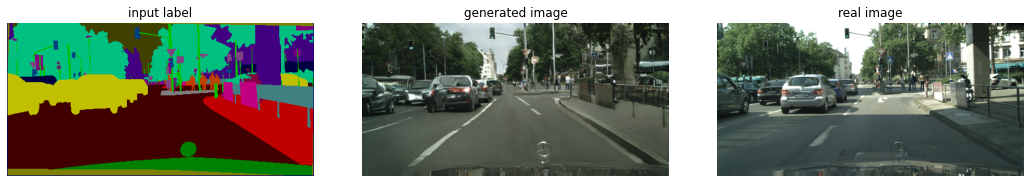

In [ ]:
#f, axs = plt.subplots(1, 2, figsize=(16, 20))
image = opt.dataroot + "/leftImg8bit/val/frankfurt/frankfurt_000000_011810_leftImg8bit.png"
evaluated_path = os.path.join(opt.results_dir, opt.name, opt.ckpt_iter)
label = evaluated_path + "/label/frankfurt_000000_011810_leftImg8bit.png"
fake = evaluated_path + "/image/frankfurt_000000_011810_leftImg8bit.png"

plt.figure(figsize=(20, 4))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(Image.open(label))
plt.axis('off')
plt.title('input label')

plt.subplot(grid_spec[1])
plt.imshow(Image.open(fake))
plt.axis('off')
plt.title('generated image')

plt.subplot(grid_spec[2])
plt.imshow(Image.open(image))
plt.axis('off')
plt.title('real image')
